# Training

In [1]:
import os
import os.path as osp
from IPython.display import clear_output

import sklearn
import pandas as pd
import torch
import clip
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from PIL import Image

from emotionpredictor.training import Trainer, SLP
from emotionpredictor.data_tools import get_loaders
import emotionpredictor.data_tools as dt

%config InlineBackend.figure_format ='retina'

In [2]:
wikiart_embeddings_path = "../_data/wikiart_embeddings/"
clip_embedding_path = osp.join(wikiart_embeddings_path, "clip")
imagenet_embedding_path =  osp.join(wikiart_embeddings_path, "imagenet")
checkpoint_path = "../neural_checkpoints/"
results_path = "../results"

In [3]:
ARTEMIS_EMOTIONS = ['amusement',
 'awe',
 'contentment',
 'excitement',
 'anger',
 'disgust',
 'fear',
 'sadness',
 'something else']

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
reports = {}

In [6]:
save_figs = False 
save_networks = True
save_results = True


## Zero shot clip

In [1133]:
emotions = ["A picutre making me feel " + emotion for emotion in ARTEMIS_EMOTIONS]
tokens = clip.tokenize(emotions).to(device)

In [1134]:
# We take RN50x16 as it is the best performing one 
model_zero_shot, _ = clip.load("RN50x16")

In [1135]:
image_features = dt.Pickle_data_loader("../data/wikiart_embeddings/clip_training/RN50x16/test/")

In [1136]:
imgs = torch.tensor([]).to(device)
from tqdm import tqdm
for x in tqdm(image_features) :
    imgs = torch.cat([imgs, x["image"]])


199it [00:06, 32.52it/s]


In [1137]:
labels = torch.tensor([])
with torch.no_grad():
    for x in image_features :
        labels = torch.cat([labels, x["label"]])
labels.shape

torch.Size([7933, 9])

In [1138]:
with torch.no_grad():
    text_features = model_zero_shot.encode_text(tokens)
    text_features = text_features.to(device)    

In [1139]:
imgs /= imgs.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * imgs.float() @ text_features.T.float()).softmax(dim=-1)


In [1037]:
metrics = ct.compute_metrics_for_threshold(similarity.detach().cpu().numpy(),
                                 labels.detach().cpu().numpy(),
                                 confusion_labels=ARTEMIS_EMOTIONS,
                                 agreement_threshold=0.501)
if save : 
    path = "../results/clip_training/zero_shot"
    if not osp.exists(path) : os.mkdir(path)
    ct.export_results(metrics, path)

In [1239]:
report = evaluation.Report(results, labels.numpy(), ARTEMIS_EMOTIONS, 0.5)

In [1338]:
reports["zero_shot"] = report 

# Training



## Train a layer for every clip architecture and imagenet 

In [1028]:
clip.available_models()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']

In [ ]:
def recreate_dir(path, new_path, ignore = None):
    ignore = ignore if ignore is not None else []
    for directory in os.listdir(path):
        if osp.isdir(osp.join(path, directory)):
            if directory is not None:
                if directory in ignore: 
                    continue
            os.mkdir(osp.join(new_path,directory))
            recreate_dir(osp.join(path,directory), osp.join(new_path,directory), ignore)
             
recreate_dir(wikiart_embeddings_path, "test", ignore = ["test", "rest", "val", "train"])

In [8]:
def train_on_dataset(path):
    """Fix the parameters for the training on the ArtEmis features"""
    loaders = get_loaders(path)
    input_shape = (loaders["train"].load_batch(0))["image"].shape[1]
    return Trainer(model = SLP(input_size = input_shape, output_size=9).to(device),
                        loss_fn = nn.BCEWithLogitsLoss(),
                        optimizer_fn = torch.optim.Adam,
                        lr = 10**-2,
                        data_loaders = loaders,
                        device = device)

In [9]:
data_path = "../_data"
wikiart_embeddings_path = osp.join(data_path, "wikiart_embeddings")
clip_embedding_path = osp.join(wikiart_embeddings_path, "clip")
imagenet_embedding_path = osp.join(wikiart_embeddings_path, "imagenet")
checkpoint_path = "../neural_checkpoints/"

models = {}
for name in ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B32', 'ViT-B16']:
    path = osp.join(clip_embedding_path, name)
    if not osp.exists(path):
        print(f"embeddings for {name} not found, please extract them before proceeding")
    name = "C-" + name #clip indicator
    models[name] = train_on_dataset(path)
    if name in os.listdir(checkpoint_path):
        models[name].model.load_state_dict(torch.load(osp.join(checkpoint_path, name)))
    
for name in ["alexnet", "resnet50"]:
    path = osp.join(imagenet_embedding_path, name)
    if not osp.exists(path):
        print(f"embeddings for {name} not found, please extract them before proceeding")
    name = "I-" + name #imagenet indicator
    models[name] = train_on_dataset(path)
    if name in os.listdir(checkpoint_path):
        models[name].model.load_state_dict(torch.load(osp.join(checkpoint_path,name)))
                                           


In [ ]:
for model in models.values() :
    model.test_network()


In [1390]:
lrs = 10.**np.arange(-2, -6, -1)
for model in models.values() : 
    model.train_eval(4, lrs = lrs)
    clear_output()

In [ ]:
for key, slp in slps.items() :
    ct.create_report(slp, ARTEMIS_EMOTIONS, False, show_fig=True, agreement_threshold=0.501)
    export_results(slp.get_last_metrics(), osp.join("../results/clip_training/",key))

In [1393]:
from ipywidgets import interact

@interact(options = ["train", "validation"])
def losses(train_val = "train"):
    if train_val == "train":
        plot_data = [pd.Series(model.epoch_losses, name=name) for name, model in models.items()]
    else :
        plot_data = [pd.Series(model.validation_losses, name=name) for name, model in models.items()]
    x = pd.DataFrame(plot_data)
    fig = px.line(x.T)
    return fig
    

interactive(children=(Text(value='train', description='train_val'), Output()), _dom_classes=('widget-interact'…

In [1431]:
if save_networks :
    for name, model in models.items() :
        PATH = osp.join(checkpoint_path, name)
        model.save_model(PATH)

In [ ]:
if save_results :
    test_results_path = osp.join(results_path, "test_results")
    if not osp.exists(test_results_path) : os.mkdir(test_results_path)
    for name, model in models.items() :
        model.create_report(ARTEMIS_EMOTIONS, show_fig = False)
        path = osp.join(test_results_path,name)
        if not osp.exists(path): os.mkdir(path)
        model.save_labels_results(path)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

## Binary classification

For classifying the emotions as positive or negative we follow the documentation of artemis and put <b>something</b> else as a separate class.

In [1328]:
import torch.nn.functional as F
import copy


In [1329]:
# Positive affect : 
positive_emotions = ARTEMIS_EMOTIONS[:4]
print(f"List of postive emotions : {positive_emotions}")

negative_emotions = ARTEMIS_EMOTIONS[4:8]
print(f"List of negative emotions : {negative_emotions}")

something_else = ARTEMIS_EMOTIONS[-1]
print(f"Non positive or negative emotion : {something_else}")

POSITIVE_MASK = torch.tensor(np.isin(ARTEMIS_EMOTIONS, positive_emotions))
NEGATIVE_MASK = torch.tensor(np.isin(ARTEMIS_EMOTIONS, negative_emotions))
SOMETHING_ELSE_MASK = torch.tensor(np.isin(ARTEMIS_EMOTIONS, something_else))

def positive_negative_binaring():
    def batch_binaring(batch):
        pos_sum = batch["label"][:,POSITIVE_MASK].sum(1)
        neg_sum = batch["label"][:,NEGATIVE_MASK].sum(1)
        sth_else_sum = batch["label"][:,SOMETHING_ELSE_MASK].sum(1)
        #one_hot_emotion = F.one_hot(torch.tensor(list(zip(pos_sum,neg_sum, sth_else_sum))).argmax(1),3)
        batch["label"] = torch.hstack([pos_sum.unsqueeze(1),
                                       neg_sum.unsqueeze(1),
                                       sth_else_sum.unsqueeze(1)])
        return batch
    return batch_binaring

def float_my_batch(batch):
    batch["label"] = batch["label"].float()
    return batch



List of postive emotions : ['amusement', 'awe', 'contentment', 'excitement']
List of negative emotions : ['anger', 'disgust', 'fear', 'sadness']
Non positive or negative emotion : something else


In [1330]:
del Trainer
from training import Trainer
imp.reload(training)


<module 'training' from '/scratch/students/2021-fall-mt-rszymcza/code/training.py'>

In [1331]:
learning_rate = 10**-2
loaders = dt.get_loaders(path = "../data/wikiart_embeddings/clip_training/RN50x16/",
                     transformations=[positive_negative_binaring(), float_my_batch])

binary_classifier = Trainer(model=SLP(input_size=768,output_size=3),
                                        loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1,1,1]).to(device)),
                                        data_loaders= loaders,
                                        optimizer_fn = torch.optim.Adam,
                                         lr = learning_rate,
                                        device=device)

binary_classifier.class_labels = ["positive", "negative", "somthing_else"]

In [1332]:
binary_classifier.test_network()

Your model is running correctly. Rejoice ! :-)


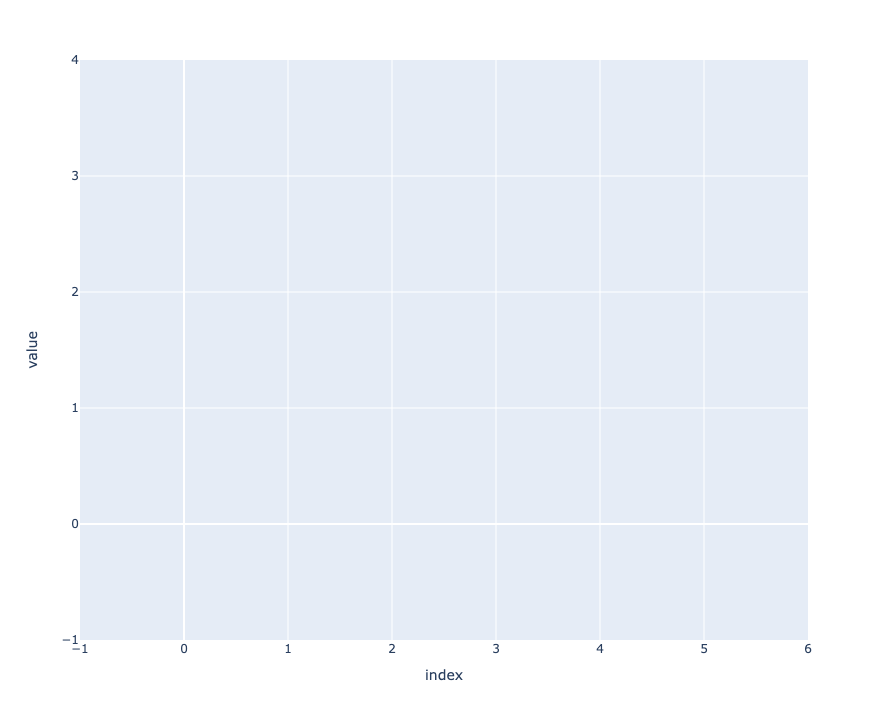

In [1339]:
lrs = [10**-2, 10**-3, 10**-4, 10**-5]
binary_classifier.train_eval(3, lrs)
clear_output()
px.line(binary_classifier.epoch_losses)

In [1335]:
ct.create_report(binary_classifier,["positive", "negative", "other"],
                 agreement_threshold=0.501,
                 normalize_confusion = False)

if save :
    path = "../results/clip_training/RN50x16/binary"
    if not osp.exists(path) : os.mkdir(path)
    export_results(binary_classifier.get_last_metrics(), path)

AttributeError: 'Trainer' object has no attribute 'reports'

In [665]:
if save :
    path = "../neural_checkpoints/slp_3_classes"
    torch.save(binary_classifier.model.state_dict(), path)

## Model trained on 9 emotions as binary classifier 



In [1011]:
result_to_binarise = slps["RN50x16"].get_last_results()["results"]


In [894]:
bineriser = positive_negative_binaring()


In [925]:
result_binarised = bineriser({"label": torch.tensor(result_to_binarise).softmax(1)})["label"].numpy()
labels_binariser = r["label"].numpy()

In [943]:
ct.compute_metrics_for_threshold(result_binarised,
                                 labels_binariser,
                                 agreement_threshold=0.501,
                                 confusion_labels = ["positive", "negative", "other"] )
#ct.plot_confusion_matrix(ct.create_confusion_matrix(labels_binariser, 
 #                                                   result_binarised))

{'agreement_threshold': 0.501,
 'labels_thresholded': array([ True,  True,  True, ...,  True, False,  True]),
 'confusion_matrix':           positive  negative  other
 positive      4888       283     21
 negative       649       754      6
 other          113        21     19,
 'precision_recall_fscore_support': (array([0.86513274, 0.71266541, 0.41304348]),
  array([0.94144838, 0.5351313 , 0.12418301]),
  array([0.90167866, 0.61126875, 0.19095477]),
  array([5192, 1409,  153])),
 'recall': 0.5335875624852555,
 'f1_score': 0.5679673928034152,
 'accuracy': 0.8381699733491265}

## Raw images

In [12]:
name = "img_size_224"
path = osp.join(data_path, "preprocessed", name)
if not osp.exists(path):
    print(f"embeddings for {name} not found, please extract them before proceeding")
clip_img = Trainer(model = SLP(input_size=150528, output_size=9).to(device),
                         loss_fn = nn.BCEWithLogitsLoss(),
                         optimizer_fn = torch.optim.Adam,
                         lr=10**-3,
                         data_loaders=img_loaders,
                         device=device)
models["Raw-img"] = clip_img

In [14]:
clip_img.lr = 10**-4
clip_img.test_network(100)

Your model is running correctly. Rejoice ! :-)


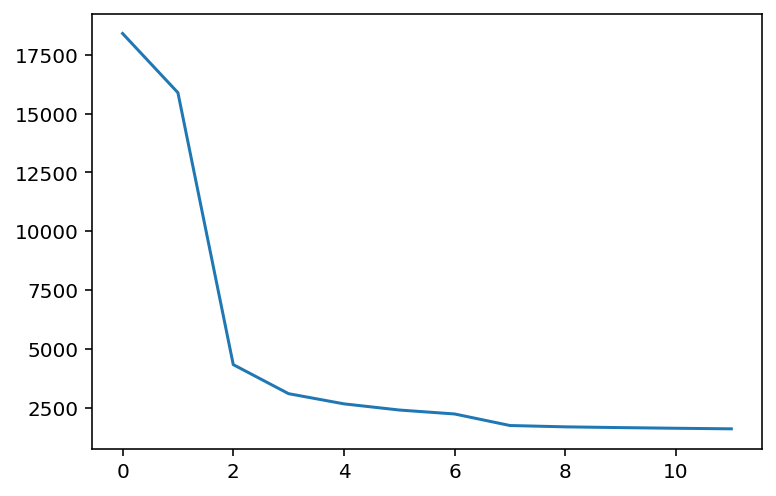

In [16]:
clip_img.train_eval(5, [10**-3,10**-4,10**-5])
clear_output()
plt.plot(clip_img.epoch_losses)

showing results with agreements of 51.0% at epoch n°11



,amusement,awe,contentment,excitement,anger,disgust,fear,sadness,something else
precision,0.09,0.17,0.56,0.04,0.0,0.02,0.13,0.11,0.03
recall,0.12,0.19,0.43,0.04,0.0,0.05,0.12,0.09,0.05
f1_score,0.10,0.18,0.49,0.04,0.0,0.03,0.13,0.10,0.04
support,230.00,387.00,1497.00,123.00,5.0,39.00,274.00,315.00,153.00



the recall is 0.12

the f1_score is 0.12

the accuracy is 0.27


<Figure size 432x288 with 0 Axes>

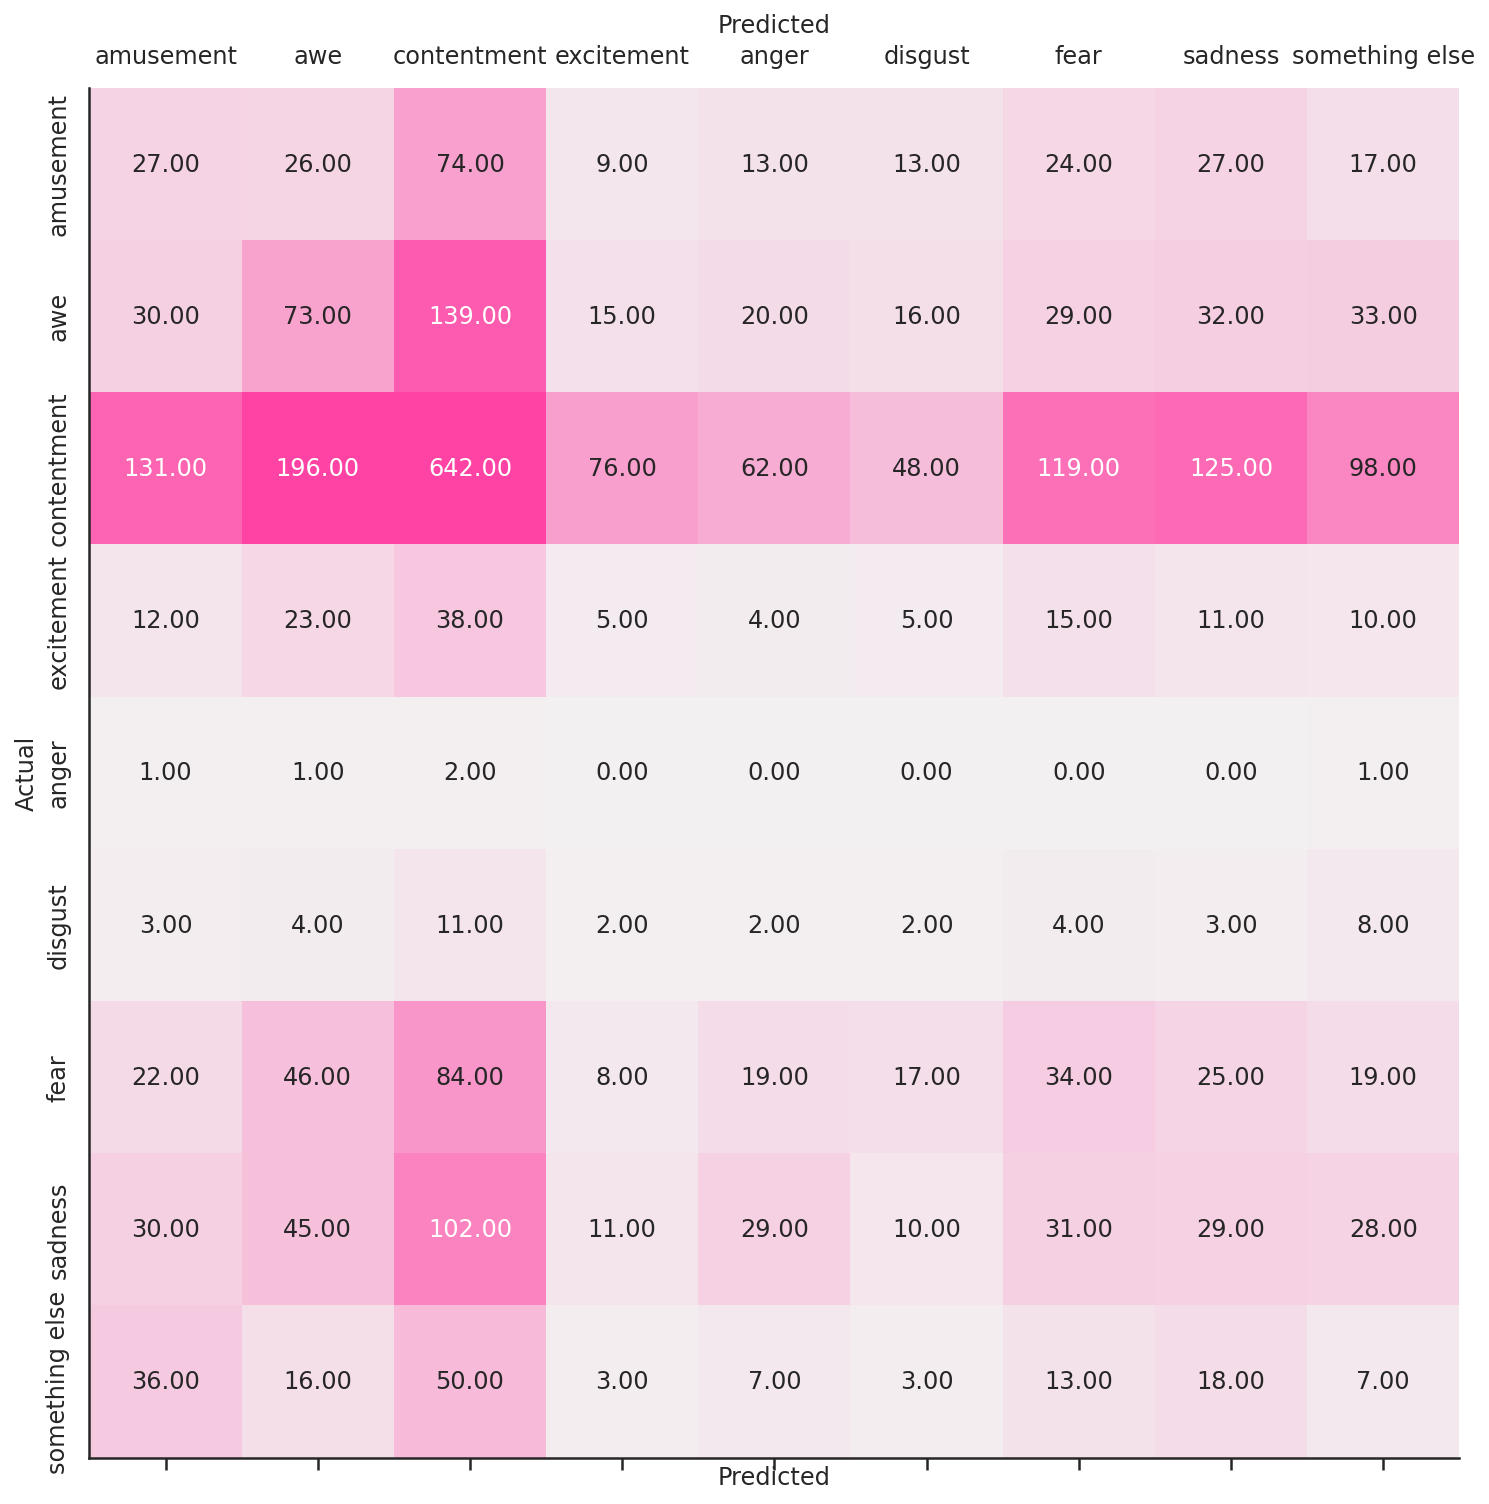

In [938]:
ct.create_report(clip_img, ARTEMIS_EMOTIONS, False, agreement_threshold=0.51)